<a href="https://colab.research.google.com/github/martydom/Bank-Marketing-Effectiveness-Prediction/blob/main/Devashish_Bose_Team_1_Bank_Marketing_Effectiveness_Prediction_Capstone_Project_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Predicting the effectiveness of bank marketing campaigns </u></b>

## <b> Problem Description </b>

### The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed. The classification goal is to predict if the client will subscribe a term deposit (variable y).


## <b> Data Description </b>

## <b>Input variables: </b>
### <b> Bank Client data: </b>

* ### age (numeric)
* ### job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
* ### marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
* ### education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
* ### default: has credit in default? (categorical: 'no','yes','unknown')
* ### housing: has housing loan? (categorical: 'no','yes','unknown')
* ### loan: has personal loan? (categorical: 'no','yes','unknown')

### <b> Related with the last contact of the current campaign:</b>
* ### contact: contact communication type (categorical: 'cellular','telephone')
* ### month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
* ### day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
* ### duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

### <b>Other attributes: </b>
* ### campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
* ### pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
* ### previous: number of contacts performed before this campaign and for this client (numeric)
* ### poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

### <b> Social and economic context attributes </b>
* ### emp.var.rate: employment variation rate - quarterly indicator (numeric)
* ### cons.price.idx: consumer price index - monthly indicator (numeric)
* ### cons.conf.idx: consumer confidence index - monthly indicator (numeric)
* ### euribor3m: euribor 3 month rate - daily indicator (numeric)
* ### nr.employed: number of employees - quarterly indicator (numeric)

### <b>Output variable (desired target):</b>
* ### y - has the client subscribed a term deposit? (binary: 'yes','no')

# **Import and Declaring helping functions**

In [ ]:
!pip install shap
!pip install catboost

     |████████████████████████████████| 358kB 5.5MB/s 
  Created wheel for shap: filename=shap-0.38.1-cp36-cp36m-linux_x86_64.whl size=489413 sha256=bd5cff27416f9c1f636af76cc43598c06604e632a8e92890412610bcc18863e9
  Stored in directory: /root/.cache/pip/wheels/a8/fb/e4/88012be41842b9be62ae18d82d1b1e880daf8539d1fef1fa00
Successfully built shap
     |████████████████████████████████| 65.8MB 57kB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# General Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set(rc={'figure.figsize':(10,6)})
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Class for Storing Fitted Models
import pickle
class save_model:
  def __init__ (self,filepath):
    self.filepath = filepath

  def load(self,name = None):
    '''
    Name : if you know the name you can extract the exact model, else you can give a specific name to extract that model.
    '''
    model_file = open(self.filepath,'rb')
    try:
      models =  pickle.load(model_file)
    except:
      model_file = {}
    model_file.close()
    if name:
      return models[name]
    else:
      return models
    

  def save(self,model,name):
    try:
      models = self.load()
    except:
      models = {}
    models[name] = model
    model_file = open(self.filepath,'wb')
    pickle.dump(models,model_file)
    model_file.close()
    return f'Dumped Model {name}'
    
  def delete(self,name):
    try:
      models = self.load()
    except:
      return f'No Models in dump'
    try:
      models.pop(name)
    except:
      return f"ENTER A VALID NAME"
    model_file = open(self.filepath,'wb')
    pickle.dump(models,model_file)
    model_file.close()
    return f'{name} Deleted'

sm = save_model('/content/drive/MyDrive/AlmaBetter/Module 4/Week 2/final_model_dump_1')

In [ ]:
# Function for plotting the counts of Categorical Variables
# plot categorical data
import seaborn as sns
import matplotlib.pyplot as plt
def plot_cat_data(df,dep_var):
  cat_columns = list(set(df.describe().columns)^set(df.columns))
  if type(df[dep_var][0])== str:
    cat_columns.remove(dep_var)
  for i,e in enumerate(cat_columns):
    plt.figure(i)
    ax = sns.countplot(df[e],hue=df[dep_var])
    for p in ax.patches:
      height = p.get_height()
      ax.text(p.get_x()+p.get_width()/2.,
              height + 3,
              '{:1.2f}'.format(height/df.shape[0]),
              ha="center")
    if(len(ax.patches)>10):
      plt.xticks(rotation=90)  
    plt.title(f'Count Plot for {e}')
    plt.show()

In [ ]:
# one hot encode categorical columns
# assumes you hae imported pandas
def oh_encode_cat(df,dep_var):
  cat_vars =  list(set(df.describe().columns)^set(df.columns))
  cat_vars.remove(dep_var)
  data = pd.DataFrame()
  for col in cat_vars:
    data = pd.concat([data,pd.get_dummies(df[col],prefix=col)],axis=1)
  return data

In [ ]:
# df = pd.read_csv("/content/drive/MyDrive/AlmaBetter/CohortAravali/Cohort Aravali/Module 4/Week 2/bank-full.csv")

In [ ]:
# importing data in a readable format
dataset = pd.read_csv('/content/drive/MyDrive/AlmaBetter/Module 4/Week 2/bank-full.csv')
extract = (lambda x : [c.replace('"','').replace('"','') for c in x.split(';')])
cols = extract(dataset.columns[0])
data = dataset.iloc[:,0].apply(extract)
# Converting Data To Numeric
def convert_numeric(dat):
  new_samples=[]
  for sample in dat:
    for i,feature in enumerate(sample):
      try:
        sample[i] = int(feature)
      except:
        continue
    new_samples.append(sample)
  return new_samples
data_new = convert_numeric(data.values)
df = pd.DataFrame(data=data_new,columns=cols)
del dataset,data,data_new

In [ ]:
# Function to do Gridsearch_CV, To be used with Load and Store Fucnction
from sklearn.metrics import *
from sklearn.model_selection import GridSearchCV
import time
from sklearn.model_selection import train_test_split
def gscv(model_dict,X,y):
  '''
  Input model_dict = {model_name:[model,param_dict,scoring_]
  '''
  X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2, random_state = 0)
  models = {'model': [], 'train_time': [],'train_accuracy': [], 'train_precision': [], 'train_recall': [], 'train_f1_score': [], 'train_tn fp fn tp': [], 'train_auc_roc': [], 'test_accuracy': [], 'test_precision': [], 'test_recall': [], 'test_f1_score': [], 'test_tn fp fn tp': [], 'test_auc_roc': []}
  for k in model_dict.keys():
    gs_model = GridSearchCV(estimator = model_dict[k][0], param_grid= model_dict[k][1], scoring=model_dict[k][2], n_jobs= -1,cv=5,)
    training_time = time.time()
    gs_model.fit(X_train,y_train)
    training_time = time.time() - training_time
    sm.save(gs_model,k)
    models['model'].append(k)
    models['train_time'].append(training_time)
    y_pred_test = gs_model.predict(X_test)
    y_pred_train = gs_model.predict(X_train)
    models['train_accuracy'].append(accuracy_score(y_train,y_pred_train))
    models['train_precision'].append(precision_score(y_train,y_pred_train))
    models['train_recall'].append(recall_score(y_train,y_pred_train))
    models['train_f1_score'].append(f1_score(y_train,y_pred_train))
    models['train_tn fp fn tp'].append(confusion_matrix(y_train,y_pred_train).flatten())
    models['train_auc_roc'].append(roc_auc_score(y_train,y_pred_train))
    models['test_accuracy'].append(accuracy_score(y_test,y_pred_test))
    models['test_precision'].append(precision_score(y_test,y_pred_test))
    models['test_recall'].append(recall_score(y_test,y_pred_test))
    models['test_f1_score'].append(f1_score(y_test,y_pred_test))
    models['test_tn fp fn tp'].append(confusion_matrix(y_test,y_pred_test).flatten())
    models['test_auc_roc'].append(roc_auc_score(y_test,y_pred_test))
  data = pd.DataFrame(models)
  sm.save(data,"Final Result")
  return data

# EDA

In [ ]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [ ]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [ ]:
ax = sns.countplot(df['y'])
for p in ax.patches:
      height = p.get_height()
      ax.text(p.get_x()+p.get_width()/2.,
              height + 3,
              '{:1.2f}'.format(height/df.shape[0]),
              ha="center")


NameError: ignored

The data is imbalanced , we can infer from the plot above.

## Plotting all the categorical features.

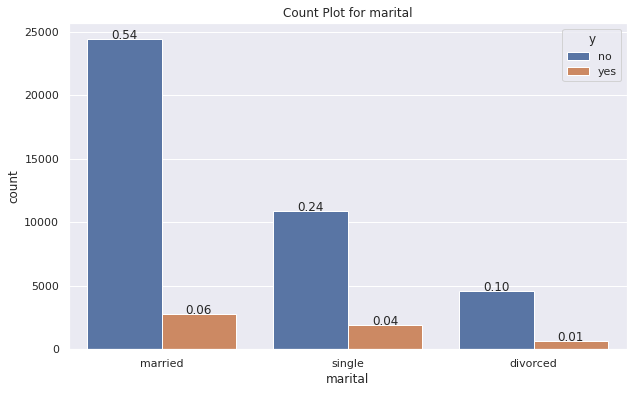

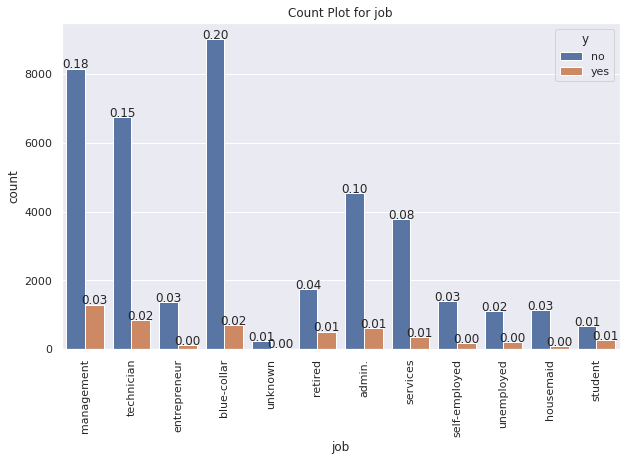

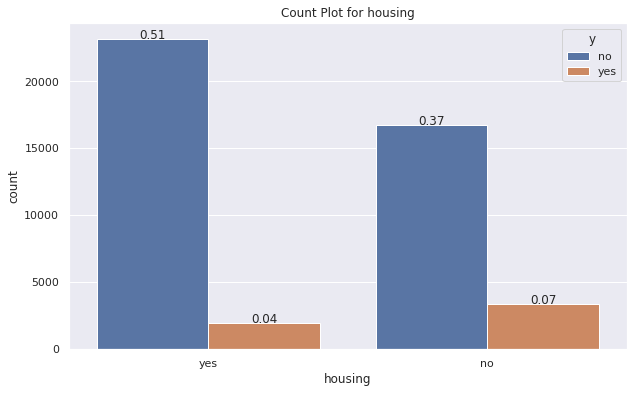

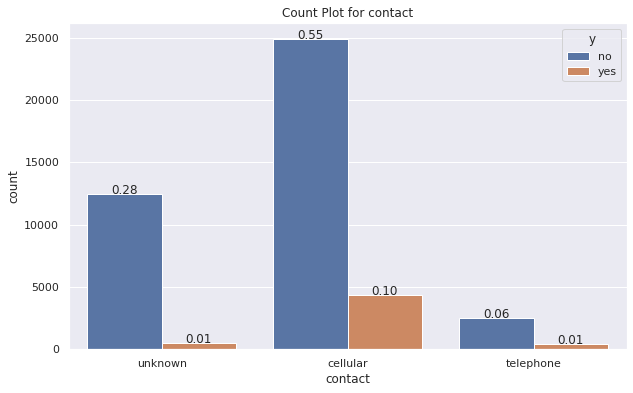

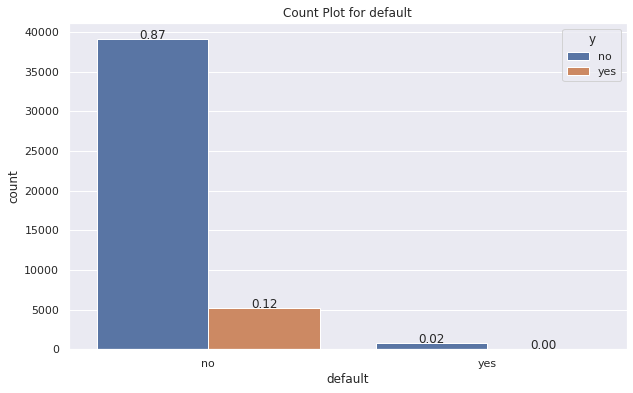

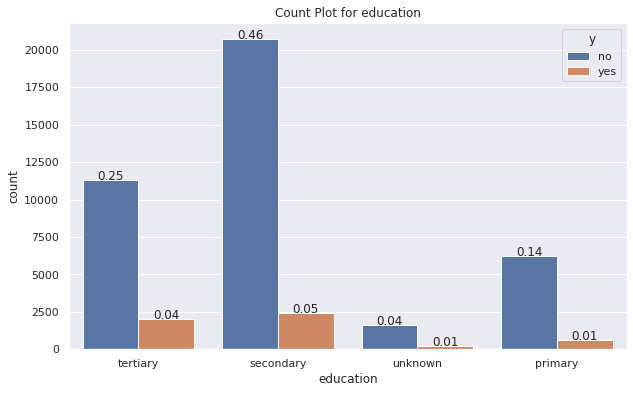

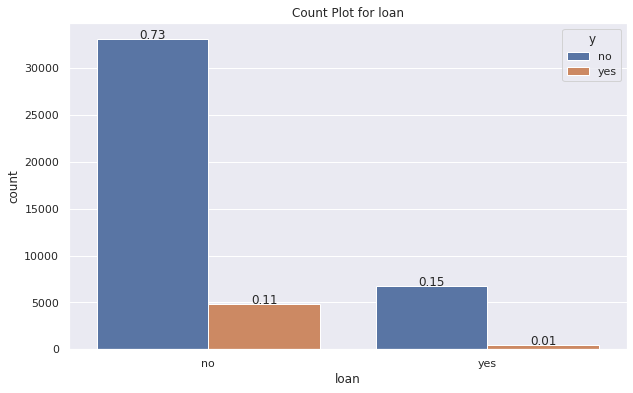

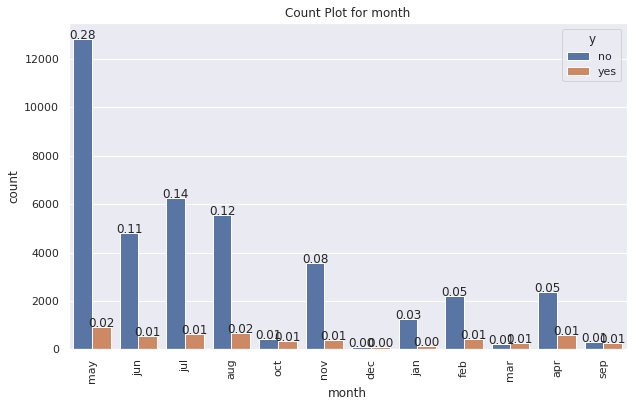

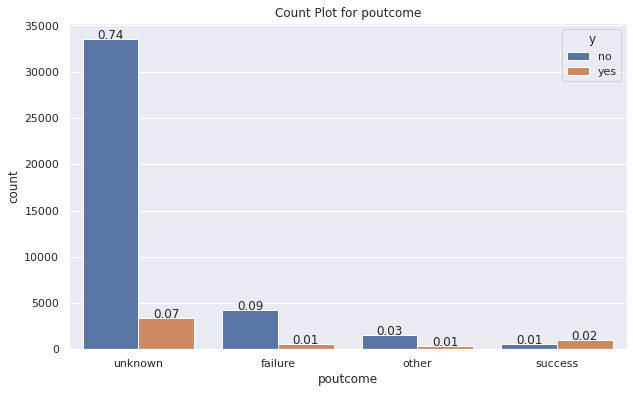

In [ ]:
plot_cat_data(df,'y')

Conclusions : 
> 1. Education is a rankwise feature where percantage of yes increases from primary >> tertiatry education
> 2. People who have housing loan are more prone to say no
> 3. There is a good chance that people who have started a term deposit before will do it again, but if they have said no earlier, there is still a chance that they will open one
>4. People who have personal loan are more prone to say no.
>5. Blue Collars reject opening a **TD** the most, whereas student and Old people buy them more.
>6. Single and married people try to save more than divorced
>7. No people who have a loan default has ever said yes
>8.Oct, mar and sep has a good ratio of acceptance/rejection
>9. People from unknown sources of contact tend to reject more

## Plotting all the numerical features.

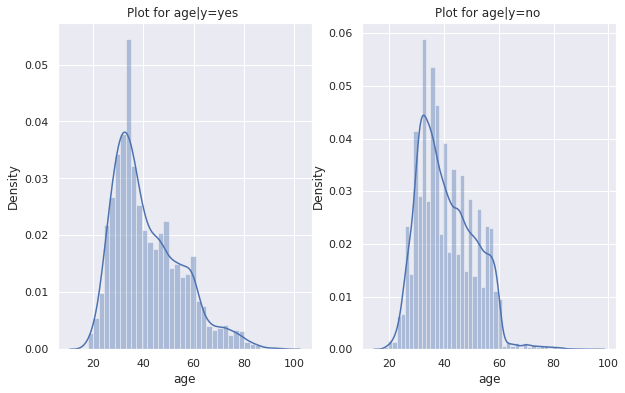

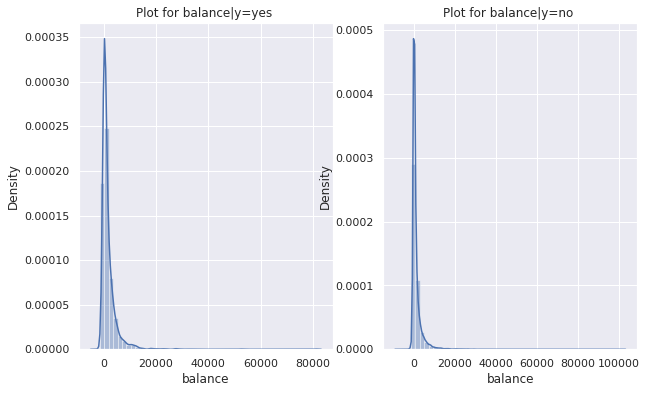

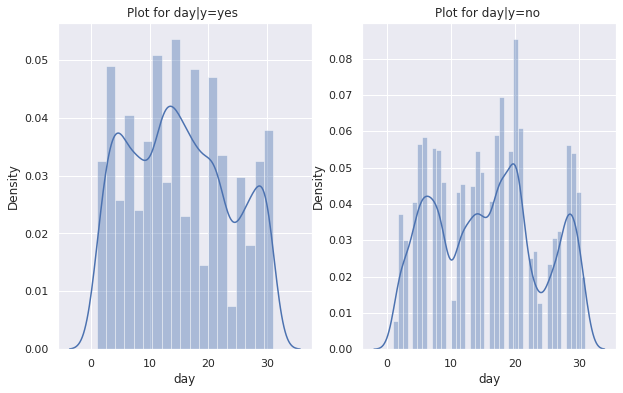

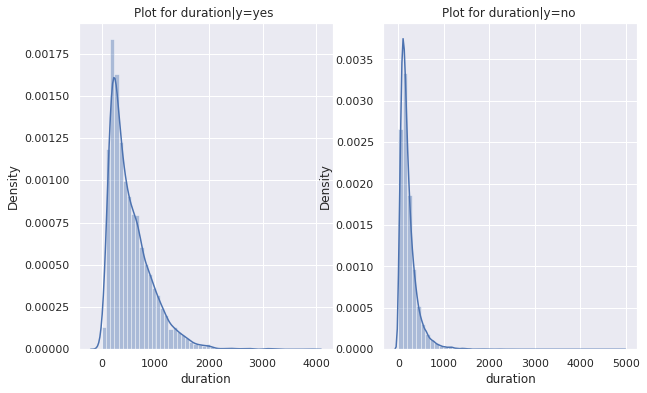

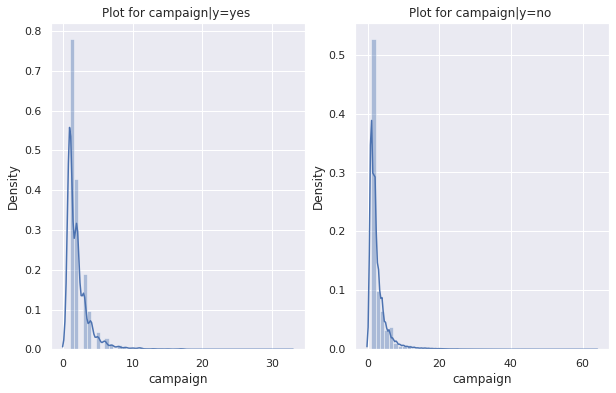

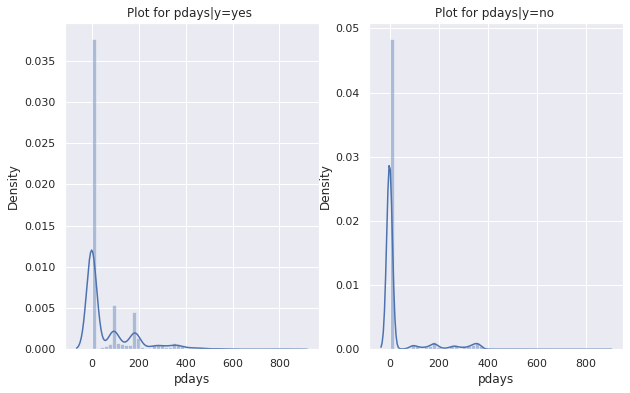

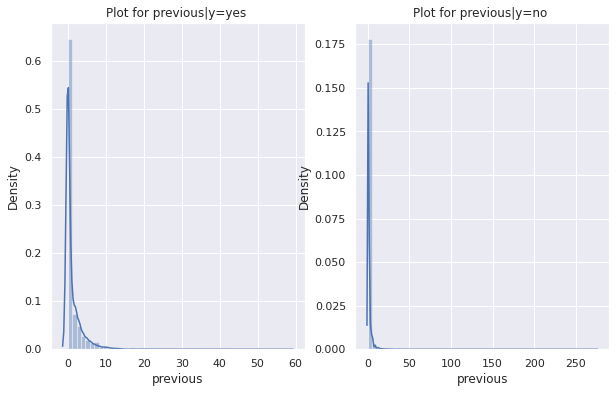

In [ ]:
for i,col in enumerate(list(df.describe().columns)):
  plt.figure(i)
  plt.subplot(1,2,1)
  sns.distplot(df[df['y']=='yes'][col])
  plt.title(f'Plot for {col}|y=yes ')
  plt.subplot(1,2,2)
  sns.distplot(df[df['y']=='no'][col])
  plt.title(f'Plot for {col}|y=no ')

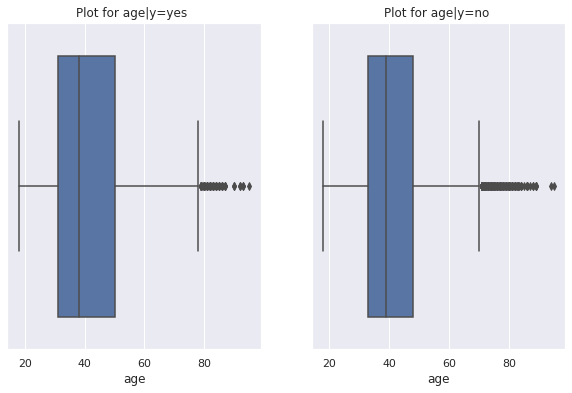

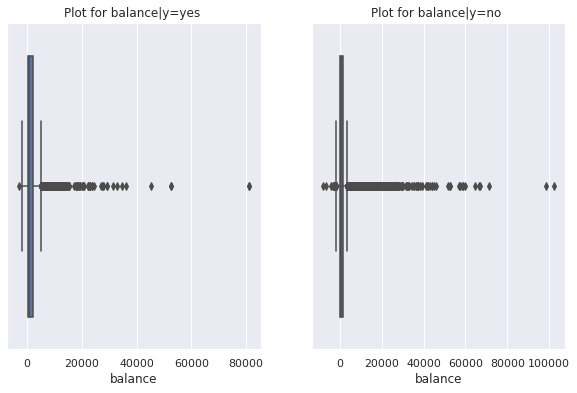

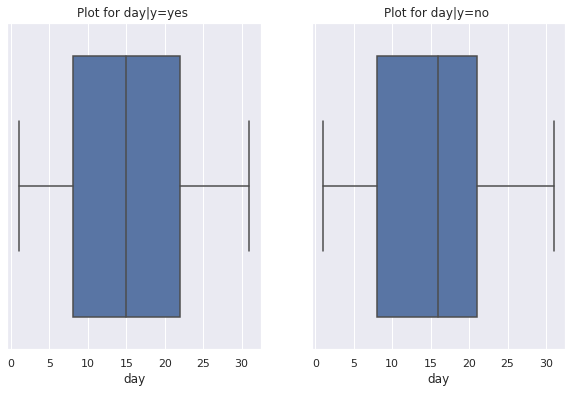

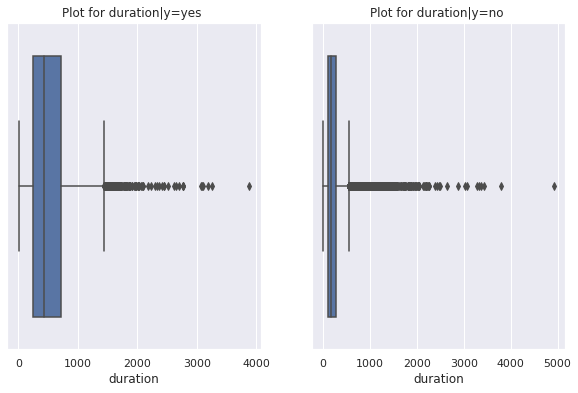

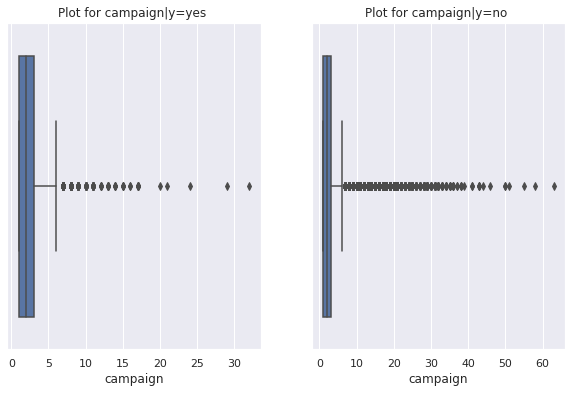

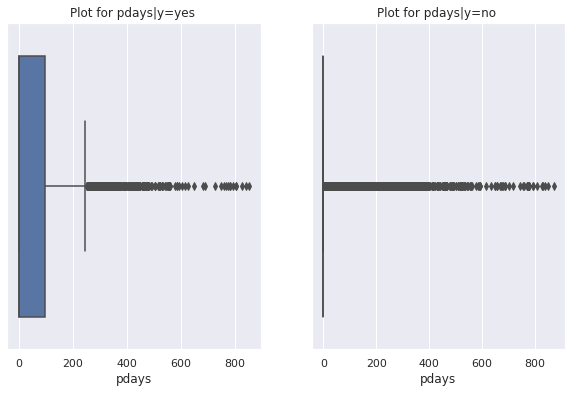

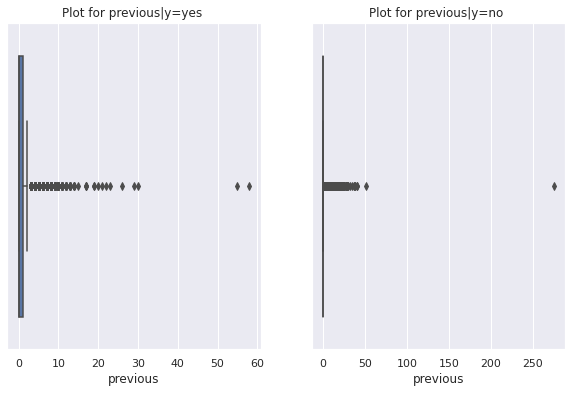

In [ ]:
for i,col in enumerate(list(df.describe().columns)):
  plt.figure(i)
  plt.subplot(1,2,1)
  sns.boxplot(df[df['y']=='yes'][col])
  plt.title(f'Plot for {col}|y=yes ')
  plt.subplot(1,2,2)
  sns.boxplot(df[df['y']=='no'][col])
  plt.title(f'Plot for {col}|y=no ')

From the plots above we can infer that there are outliers in few columns which are to be removed.

In [ ]:
# Target Variable
df['y'].replace({'no':0,'yes':1},inplace=True)

## **Feature Engineering**

In [ ]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,0
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,0


Changing the categorical Variables or Holding them for One hot Encoding

In [ ]:
one_hot_enc_cols = []

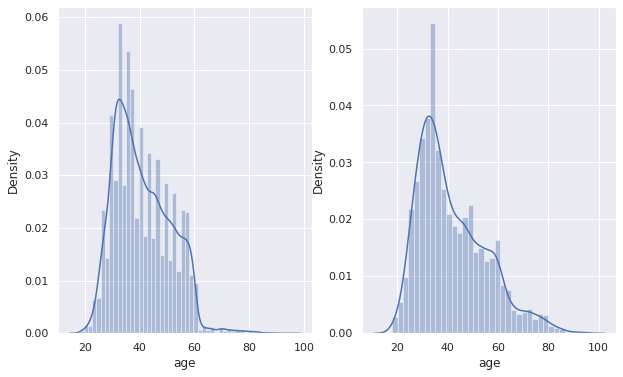

In [ ]:
#AGE
#we decided to categorise age in 4 bins by looking its distribution graphs
plt.subplot(1,2,1)
sns.distplot(df[df['y']==0]['age'])
plt.subplot(1,2,2)
sns.distplot(df[df['y']==1]['age'])

In [ ]:
def convert_age(age):
  if age<33:
    return 'struggling'
  elif age<45:
    return 'stable'
  elif age<60:
    return 'about_to_retire'
  elif age<67:
    return 'old_age'
  else:
    return 'counting_last_breaths'

In [ ]:
df['cat_age'] = df['age'].apply(convert_age)

In [ ]:
df['cat_age'].value_counts()

stable                   18436
about_to_retire          13880
struggling               11111
old_age                   1096
counting_last_breaths      688
Name: cat_age, dtype: int64

In [ ]:
one_hot_enc_cols.append('cat_age')

In [ ]:
#job
def cluster_jobs(job):
  new_cat1 = ['technician','services']
  new_cat2 = ['blue-collar','admin.']
  new_cat3 = ['self-employed','housemaid','entrepreneur']
  if job in new_cat1:
    return 'cat1'
  if job in new_cat2:
    return 'cat2'
  if job in new_cat3:
    return 'cat3'
  return job

In [ ]:
df['new_jobs'] = df['job'].apply(cluster_jobs)

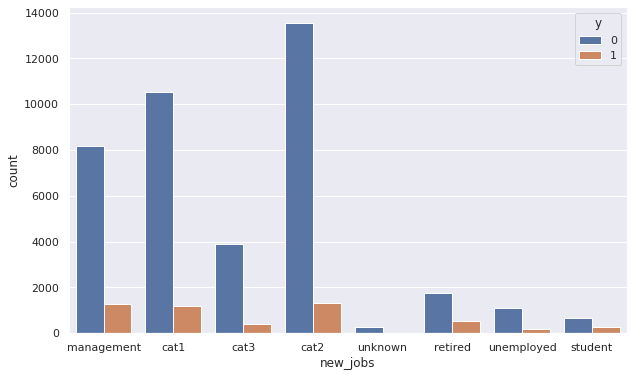

In [ ]:
sns.countplot(df['new_jobs'],hue=df['y'])

In [ ]:
one_hot_enc_cols.append('new_jobs')

## Encoding categorical features.

In [ ]:
#marital
one_hot_enc_cols.append('marital')

In [ ]:
#education
one_hot_enc_cols.append('education')

In [ ]:
#default
df.default.replace({'no':0,'yes':1},inplace=True)

In [ ]:
#balance
#will Scale Later

In [ ]:
#housing
df.housing.replace({'no':0,'yes':1},inplace=True)

In [ ]:
#loan default
df.loan.replace({'no':0,'yes':1},inplace=True)

In [ ]:
#contact
df.contact.replace({'unknown':0, 'cellular':1, 'telephone':1},inplace=True)

Decided to drop (Day, Month, Duration) as all of these are futuristic columns or irrelevant to the model.

In [ ]:
#poutcome
one_hot_enc_cols.append('poutcome')

In [ ]:
one_hot_enc_cols

['cat_age', 'new_jobs', 'marital', 'education', 'poutcome']

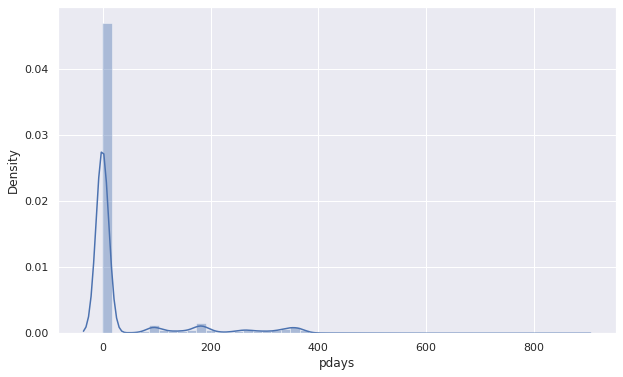

In [ ]:
sns.distplot(df['pdays'])

In [ ]:
# assigning 1 to all those who are contacted before.
df['contacted_before']=df['pdays'].apply(lambda x : 1 if x!=-1 else 0 )

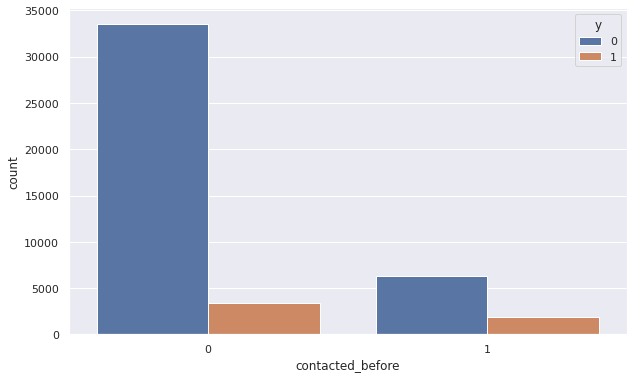

In [ ]:
sns.countplot(df['contacted_before'],hue = df['y'])

## Checking out our new variable and all the modifications made above.

In [ ]:
new_df = pd.get_dummies(df.drop(['age','job','pdays','day','month','duration'],axis=1),columns = one_hot_enc_cols)

In [ ]:
new_df.head()

,default,balance,housing,loan,contact,campaign,previous,y,contacted_before,cat_age_about_to_retire,cat_age_counting_last_breaths,cat_age_old_age,cat_age_stable,cat_age_struggling,new_jobs_cat1,new_jobs_cat2,new_jobs_cat3,new_jobs_management,new_jobs_retired,new_jobs_student,new_jobs_unemployed,new_jobs_unknown,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,0,2143,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1
1,0,29,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1
2,0,2,1,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1
3,0,1506,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1
4,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1


IQR

In [ ]:
#@title Code for IQR for one variable.
# percentile_q1_balance = np.percentile(df['balance'],25)
# print(percentile_q1_balance)
# percentile_q2_balance = np.percentile(df['balance'],50)
# print(percentile_q2_balance)
# percentile_q3_balance = np.percentile(df['balance'],75)
# print(percentile_q3_balance)
# iqr=percentile_q3_balance - percentile_q1_balance
# lower_limit_outlier=percentile_q1_balance-1.5*iqr
# upper_limit_outlier=percentile_q3_balance+1.5*iqr
# print("lower limit for outlier  :",lower_limit_outlier)
# print("Upper limit for outlier  :",upper_limit_outlier)
# final_df=new_df[(new_df['balance']>lower_limit_outlier)&(new_df['balance']<upper_limit_outlier)]

## **Using Isolation Forest for anomaly detection.**

In [ ]:
feature_df = new_df.drop(['y'],axis=1)
from sklearn.ensemble import IsolationForest
anomaly_filter = IsolationForest(contamination=0.1,n_jobs=-1)
anomalies = pd.Series(anomaly_filter.fit_predict(feature_df))
new_df['is_anomaly'] = anomalies
final_df = new_df[new_df['is_anomaly']==1].drop(['is_anomaly'],axis=1)

## Scaling the features

In [ ]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
final_df_scaled = pd.DataFrame(mms.fit_transform(final_df.drop('y',axis=1).values),columns=final_df.drop('y',axis=1).columns)

In [ ]:
final_df_scaled.shape

(40690, 32)

In [ ]:
final_df_scaled.head()

,default,balance,housing,loan,contact,campaign,previous,contacted_before,cat_age_about_to_retire,cat_age_counting_last_breaths,cat_age_old_age,cat_age_stable,cat_age_struggling,new_jobs_cat1,new_jobs_cat2,new_jobs_cat3,new_jobs_management,new_jobs_retired,new_jobs_student,new_jobs_unemployed,new_jobs_unknown,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,0.0,0.082497,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.063098,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.062850,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.076651,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.0,0.062841,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [ ]:
final_df_scaled['y'] = final_df.y

In [ ]:
final_df_scaled =final_df_scaled[~final_df_scaled.isin([np.nan, np.inf, -np.inf]).any(1)]

## Oversampling using SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE
sampler = SMOTE()
X,y = sampler.fit_resample(final_df_scaled.drop(['y'],axis=1).values,final_df_scaled['y'].values)

# **Applying our Machine Learning Models**

In [ ]:
model_dict = {}

In [ ]:
#Logistic Reg
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
params = {'C': [0.1,1.0,10], 'l1_ratio': [0.5], 'max_iter': [1000,10000], 'penalty': ['l2','l1','elasticnet'], 'solver': ['saga']}
metric ='roc_auc'
model_dict['Logistic Regression'] = [lr,params,metric]

#random forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
params = {'criterion': ['gini','entropy'], 'max_depth': [5,10], 'min_samples_leaf': [10], 'n_estimators': [50,80,120]}
metric = 'roc_auc'
model_dict['Random Forest'] = [rf,params,metric]

#XGB
from xgboost import XGBClassifier
xgb = XGBClassifier()
params = {'learning_rate': [0.01,0.1,0.5], 'max_depth': [5,10], 'n_estimators': [50,80,120], 'reg_lambda': [0.1,1,10], 'seed': [123]}
metric = 'roc_auc'
model_dict['XG Boost'] = [xgb,params,metric]

#SVM
from sklearn.svm import SVC
svc = SVC()
params = {'C': [0.1,1.0,10], 'kernel': ['rbf','polynomial']}
metric = 'roc_auc'
model_dict['SVM'] = [svc,params,metric]

#KNN
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
params = {'n_neighbors': [5,7]}
metric = 'roc_auc'
model_dict['KNN'] = [knn,params,metric]

#catboost
from catboost import CatBoostClassifier
cbc = CatBoostClassifier()
params = {}
metric = 'roc_auc'
model_dict['CatBoost'] = [cbc,params,metric]

#SGD
from sklearn.linear_model import SGDClassifier
sgdc = SGDClassifier()
params = {}
metric = 'roc_auc'
model_dict['CatBoost'] = [sgdc,params,metric]

In [ ]:
gscv(model_dict,X,y)

,model,train_time,train_accuracy,train_precision,train_recall,train_f1_score,train_tn fp fn tp,train_auc_roc,test_accuracy,test_precision,test_recall,test_f1_score,test_tn fp fn tp,test_auc_roc
0,Logistic Regression,325.275471,0.606623,0.589487,0.690438,0.635981,"[14804, 13471, 8673, 19344]",0.607005,0.606651,0.598311,0.692157,0.641822,"[3578, 3330, 2206, 4960]",0.605054
1,Random Forest,125.404775,0.729216,0.704764,0.784631,0.742556,"[19066, 9209, 6034, 21983]",0.729468,0.722822,0.707039,0.777979,0.740815,"[4598, 2310, 1591, 5575]",0.721792
2,XG Boost,1983.889241,0.938926,0.945546,0.930899,0.938165,"[26773, 1502, 1936, 26081]",0.938889,0.868410,0.884738,0.852637,0.868391,"[6112, 796, 1056, 6110]",0.868704
3,SVM,3040.265098,0.712464,0.695083,0.752293,0.722557,"[19029, 9246, 6940, 21077]",0.712645,0.706054,0.697175,0.747279,0.721358,"[4582, 2326, 1811, 5355]",0.705284
4,KNN,161.958930,0.864492,0.852910,0.879395,0.865950,"[24026, 4249, 3379, 24638]",0.864560,0.790109,0.789843,0.800865,0.795316,"[5381, 1527, 1427, 5739]",0.789909
5,CatBoost,2.075147,0.589320,0.559661,0.820145,0.665315,"[10196, 18079, 5039, 22978]",0.590373,0.601037,0.575109,0.828635,0.678978,"[2521, 4387, 1228, 5938]",0.596787


## Stacking

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

def get_stacking(X,y):
  level0 = list()
  X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2)
  for name in sm.load('Final Result').model.unique():
    level0.append((name, sm.load(name).best_estimator_))
	# define meta learner model
  level1 = LogisticRegression()
	# define the stacking ensemble
  model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
  model.fit(X_train,y_train)
  sm.save(model,'Stacking')
  sm.save((X_test,y_test),'Stacking Test Data')
  return model,X_test,y_test

In [ ]:
#print Test Scores
stack,valid_x,valid_y = get_stacking(X,y)
y_pred = stack.predict(valid_x)
# scores(valid())

In [ ]:
print(f'Stacking Accuracy : {accuracy_score(valid_y,y_pred)}')

Stacking Accuracy : 0.8760835583345176


In [ ]:
print(f'Stacking Precision : {precision_score(valid_y,y_pred)}')

Stacking Precision : 0.8854453294713975


In [ ]:
print(f'Stacking Recall : {recall_score(valid_y,y_pred)}')

Stacking Recall : 0.8651478703834725


In [ ]:
print(f'Stacking AUC : {roc_auc_score(valid_y,y_pred)}')

Stacking AUC : 0.8761303787481799


In [ ]:
confusion_matrix(valid_y,y_pred)

array([[6216,  791],
       [ 953, 6114]])

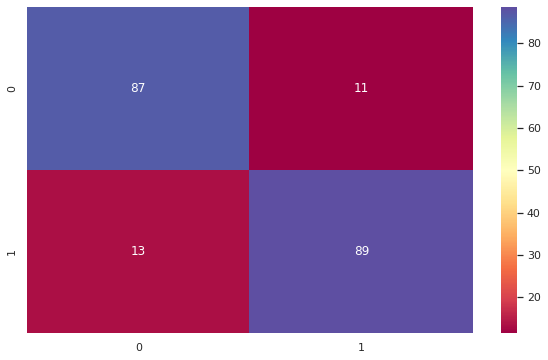

In [ ]:
sns.heatmap(confusion_matrix(valid_y,y_pred)/sum(confusion_matrix(valid_y,y_pred))*100,annot=True,cmap='Spectral')

Plotting Features

In [ ]:
import shap
def show_feature_importance():
  shap.initjs()
  model_df = sm.load("Final Result")
  models = model_df.model.unique()
  i=0
  for model in models:
    try:
      est = sm.load(model).best_estimator_
      explainer = shap.Explainer(est)
      shap_values = explainer.shap_values(X)
      plt.figure(i)
      shap.summary_plot(shap_values, features=X, feature_names=list(final_df_scaled.drop(['y'],axis=1).columns))
      plt.title(f"Feature importance for {model} ")
      plt.show()
      i+=1
      plt.figure(i)
      plt.title(f"Feature importance for {model} ")
      shap.summary_plot(shap_values, features=X, feature_names=list(final_df_scaled.drop(['y'],axis=1).columns), plot_type='bar')
      plt.show()
      i+=1
    except:
      continue

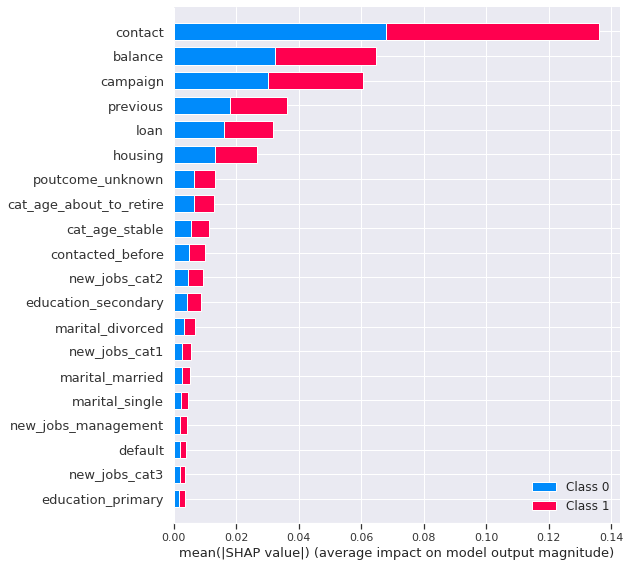

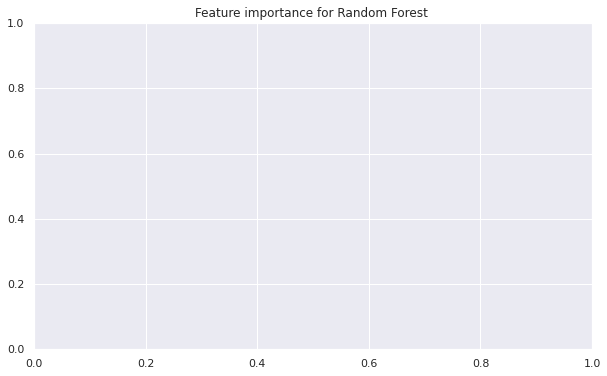

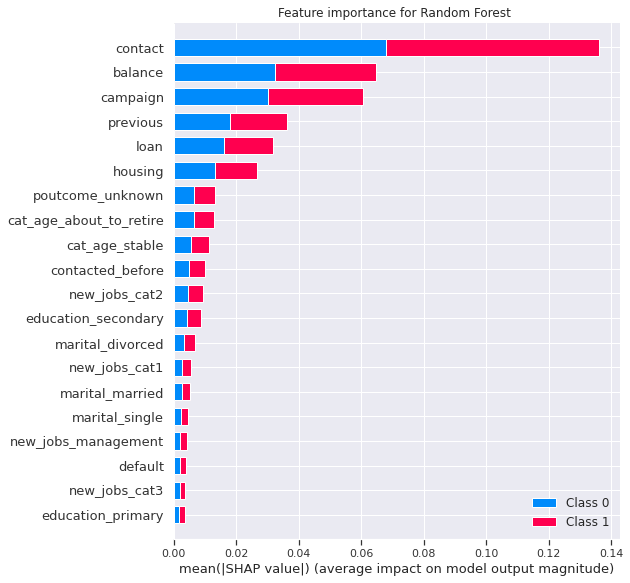

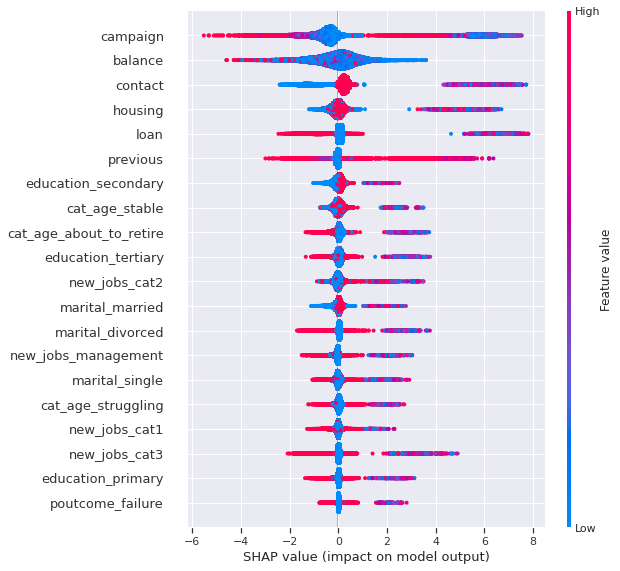

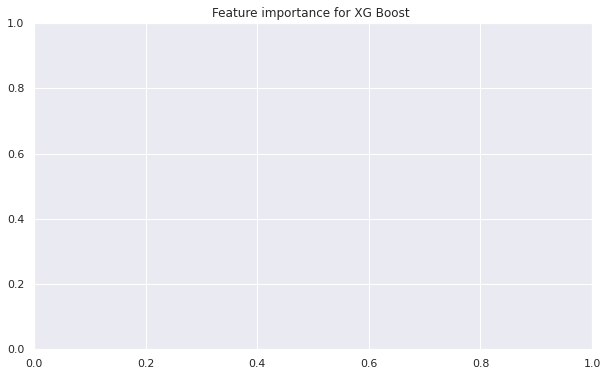

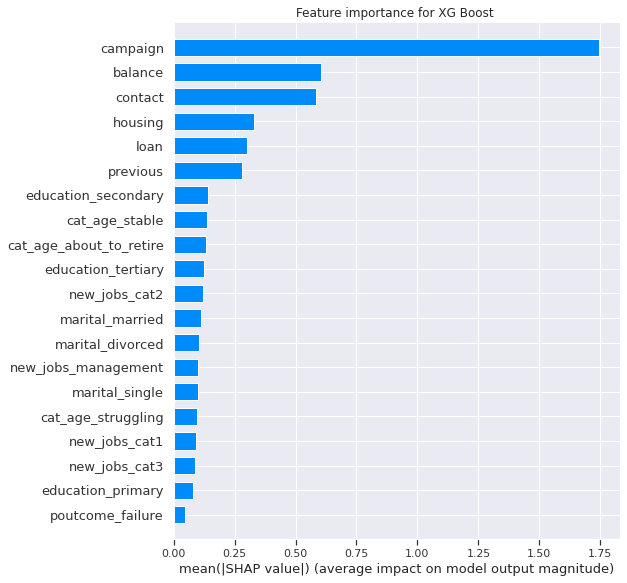

In [ ]:
show_feature_importance()

##Conclusion

XGBoost has shown the best performance, but in the end it was able to identify slightly more that a half of positive outcomes, which tells me there must be ways to improve it. Maybe I need more data or modify what I have. The data science process never ends.

Key outcomes of the analysis are the recommendations for future marketing campaigns:


*   The customer's account balance has a huge influence on the campaign's outcome. People with account balance above 1490$ are more likely to subscribe for term deposit, so future address those customers.

*   The customer's age affects campaign outcome as well. Future campains should concentrate on customers from age categories below 30 years old and above 50 years old.

*   Number of contacts with the customer during the campaign is also very important. The number of contacts with the customer shouldn't exceed 4.